In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s6e1/train.csv')


In [3]:
train.head(5)

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


In [12]:
num_cols = ['age','study_hours','class_attendance','sleep_hours']
cat_cols = ['gender','course','internet_access','sleep_quality',
            'study_method','facility_rating','exam_difficulty']

target_col = 'exam_score'

# -----------------------------
# 2️⃣ Fill missing values
for col in num_cols:
    train[col] = train[col].fillna(train[col].median())

for col in cat_cols:
    train[col] = train[col].fillna(train[col].mode()[0])

In [13]:
X = train[num_cols + cat_cols]
y = train[target_col]

# -----------------------------
# 4️⃣ Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

In [18]:
xgb = XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

# -----------------------------
# 7️⃣ Full Pipeline: preprocessing + model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb)
])

In [19]:
train.isnull().sum()

id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64

In [28]:
param_dist = {
    'regressor__n_estimators': [200, 300, 400],
    'regressor__max_depth': [4, 5, 6],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__subsample': [0.8, 0.9],
    'regressor__colsample_bytree': [0.8, 0.9],
    'regressor__gamma': [0, 0.1],
    'regressor__min_child_weight': [1, 3]
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=25,          # quick tuning
    scoring='neg_root_mean_squared_error',
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [29]:
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# -----------------------------
# 10️⃣ Predictions
y_pred = best_model.predict(X_val)


Fitting 2 folds for each of 25 candidates, totalling 50 fits
Best Parameters: {'regressor__subsample': 0.8, 'regressor__n_estimators': 400, 'regressor__min_child_weight': 1, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.05, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.9}


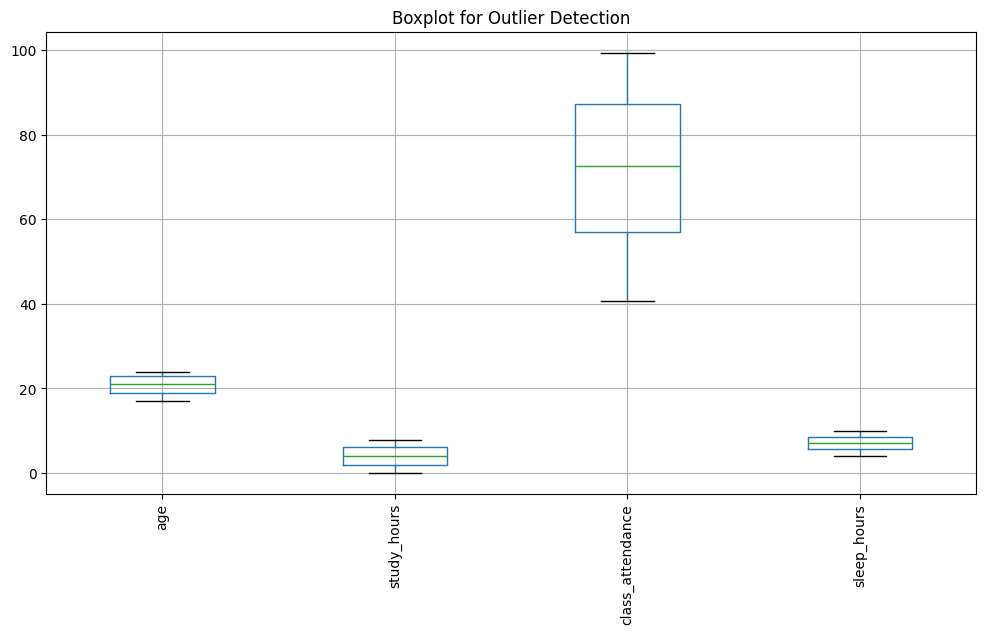

In [31]:
plt.figure(figsize=(12,6))
train[num_cols].boxplot(rot=90)
plt.title("Boxplot for Outlier Detection")
plt.show()


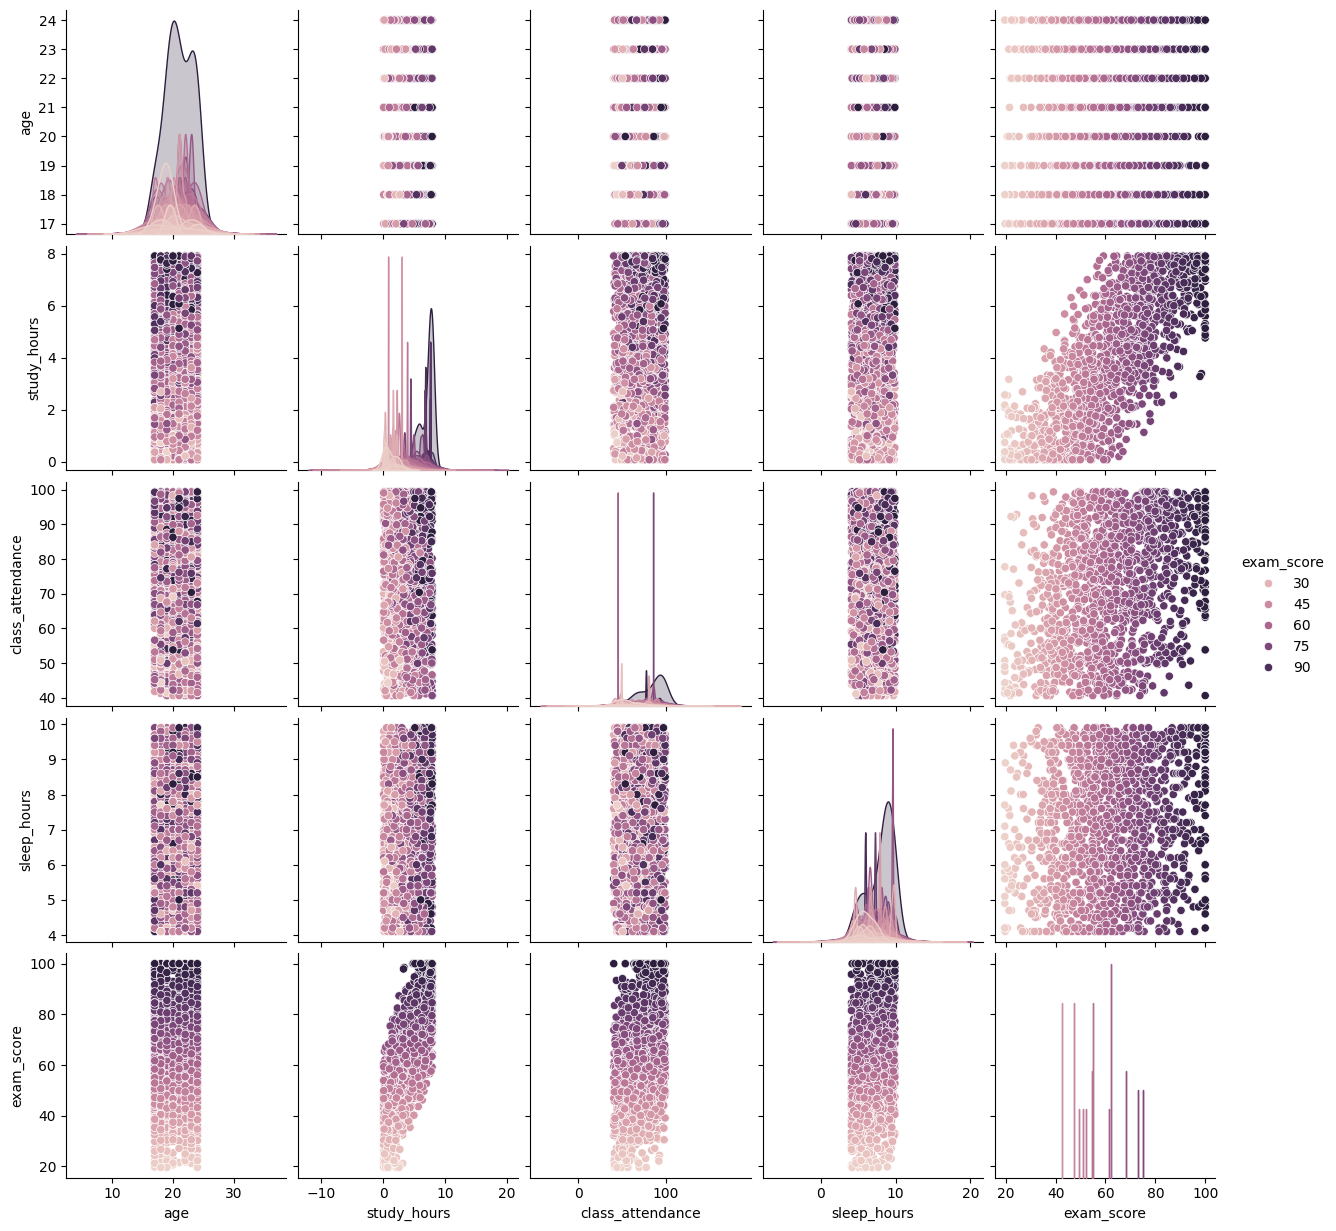

In [14]:

import seaborn as sns
sns.pairplot(train.sample(1500), vars=num_cols, hue='exam_score')
plt.show()


In [32]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Validation RMSE:", rmse)
print("Validation MAE:", mae)
print("Validation R² Score:", r2)


Validation RMSE: 8.762237243820143
Validation MAE: 6.987922745831324
Validation R² Score: 0.7841208616321834


In [35]:
import pandas as pd

# 1️⃣ Load test data
test = pd.read_csv('/kaggle/input/playground-series-s6e1/test.csv')

# 2️⃣ Save test IDs
test_ids = test['id']

# 3️⃣ Drop 'id' from features
X_test = test.drop(columns=['id'])
test_preds = best_model.predict(X_test)
submission = pd.DataFrame({
    'id': test_ids,
    'exam_score': test_preds  # regression predictions
})

# 6️⃣ Save to CSV
submission.to_csv('submission.csv', index=False)